In [7]:
import numpy as np
from scipy.special import logsumexp
import matplotlib.pyplot as plt

import time

In [2]:
np.random.seed(3698)

d = 20  # Dimension of the Gaussians

n = 100
m = 50 

k_star = 5  # Order of the Wishart distribution, i.e. dimension of the support of the Gaussians

# Equal weights
a = np.ones(n) / n
b = np.ones(m) / m

# Zero means
mean_1 = np.zeros(d)
mean_2 = np.zeros(d)

# Covariances from Wishart
cov_1 = np.random.randn(d, k_star)
cov_1 = cov_1.dot(cov_1.T)
cov_2 = np.random.randn(d, k_star)
cov_2 = cov_2.dot(cov_2.T)

k = 10

# Empirical measures with n points
X = np.random.multivariate_normal(mean_1, cov_1, size=n)
Y = np.random.multivariate_normal(mean_2, cov_2, size=m)

U0, _ = np.linalg.qr(np.random.randn(d, k))

tau = 0.1
eta = 10

In [32]:
n, d = X.shape
m, d = Y.shape

u = a
v = b

U = U0

log = dict()
log['f'] = []

while True:
    # Compute pi using current U
    projX = X @ U
    projY = Y @ U
    C = ((projX[..., None] - projY[..., None].T) ** 2).sum(1)
    log_pi = (u[:, None] + v[None, :] - C) / eta

    # Update u
    log_ak = logsumexp(log_pi, -1)
    u = u + np.log(a) - log_ak

    # Update v
    log_bk = logsumexp(log_pi, 0)
    v = v + np.log(b) - log_bk

    # Compute Vpi using new u and v
    pi = np.exp(log_pi)
    A = X.T @ pi @ Y
    Vpi = X.T @ np.diag(pi.sum(-1)) @ X + Y.T @ np.diag(pi.sum(0)) @ Y - A - A.T

    # Compute xi using new Vpi and current U
    G = 2. / eta * Vpi @ U
    temp = G.T @ U
    xi = G - U @ (temp + temp.T) / 2.

    # Compute U^{(t+1)}
    U, _ = np.linalg.qr(U + tau * xi)

    # Log
    f = np.trace(U.T @ Vpi @ U)
    log['f'].append(f)

    # Check stopping condition
    grad_norm = np.linalg.norm(xi)
    if eta * grad_norm <= 0.01:
        break

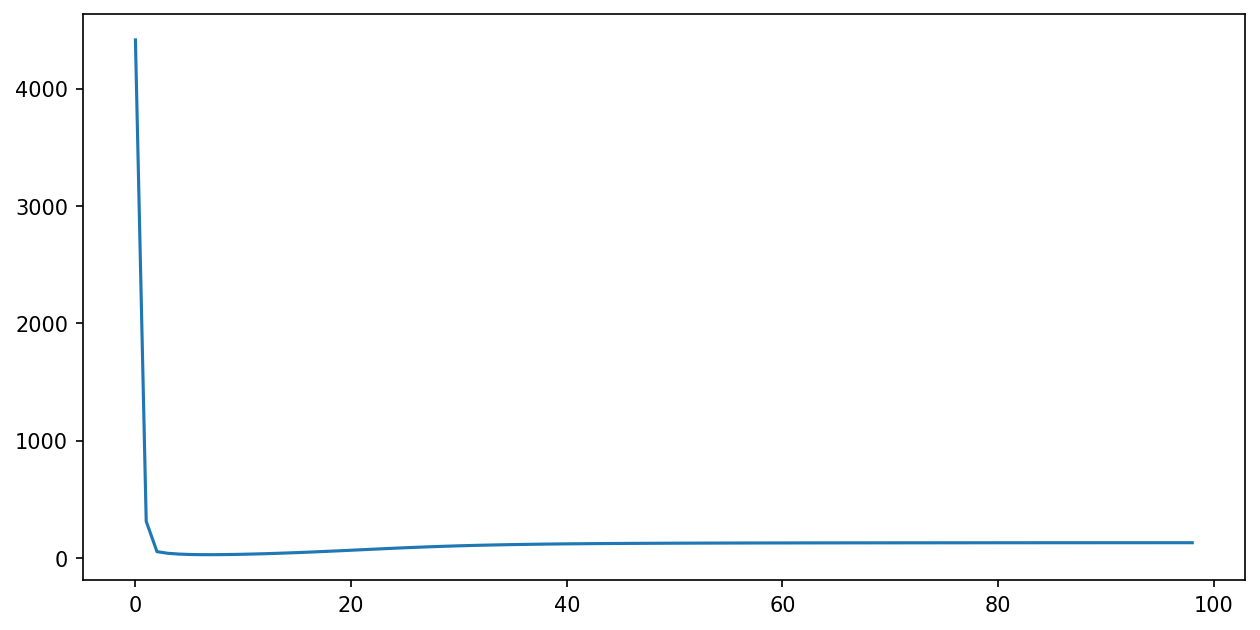

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=150)
ax.plot(log['f'])

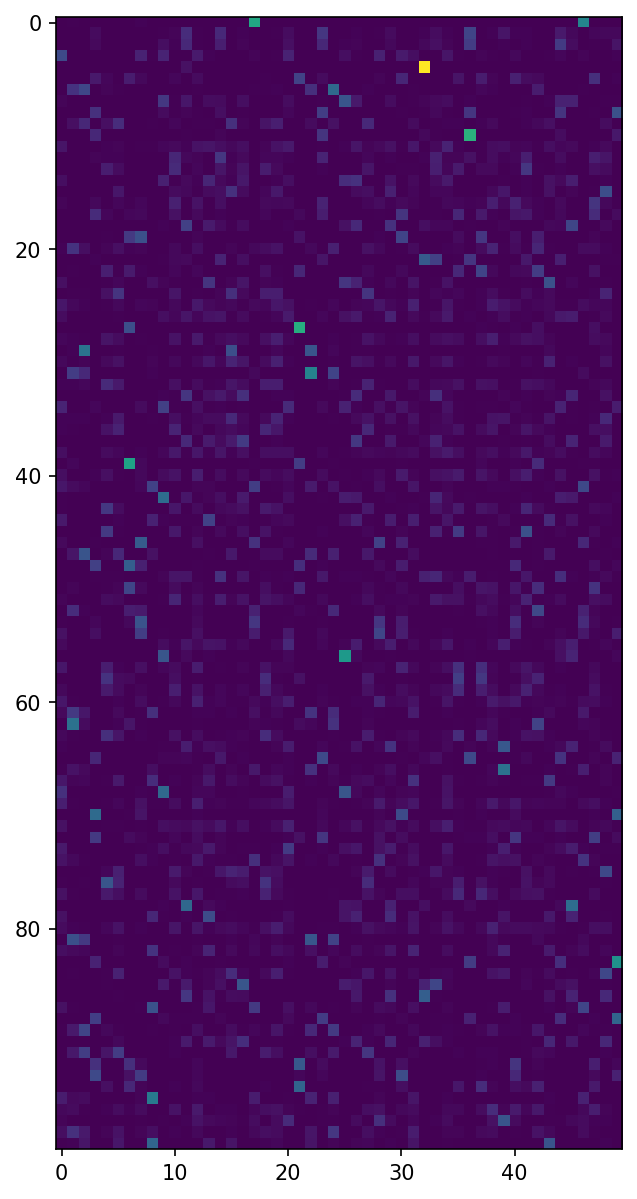

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(5, 10), dpi=150)
plt.imshow(pi)